In [1]:
from imports import *

import warnings
warnings.filterwarnings('ignore')

import acquire
import prepare
import explore
import model

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Acquisition

In this stage, we use a SQL query to access the Codeup MySQL database and join data from each of the tables in the superstore database. The data obtained includes sales record transactions for SuperStore from 2014 - 2017. 

The `get_data` function performs this acquisition.

In [2]:
# acquire data from the Codeup cloud database
df = acquire.get_data()

Reading from local CSV...


# Preparation

In this stage, we clean and prepare the data for further exploration analsys and enccapsulate the relevant code in the prepare module.

The `prep_data` function accomplishes the following:

- renames columns for convenience
- casts date columns as datetime types
- resets the dataframe index as a datetime (order_date)
- adds engineered features:
    - profit-per-product
    - sales-per-product

In [3]:
df = prepare.prep_data(df)

#### Splitting the data

In order to retain the ability to use our insights to make predictions, we only explored interactions between variables for years 2014-2016 by splitting the dataframe into train and test based on year. The test dataframe contains information from 2017 and the train dataframe contains the previous years. 

The `split_data` function performs this action

In [4]:
# split data into train (2014-2016) and test (2017)
train, test = prepare.split_data(df)

train n= 1238
test n= 496


#### Handling Outliers

While an initial exploration of the data revealed significant outliers in sales and proft, we decided not to remove them for this project. 

Since our goal is to find a category of products that stand out from the others in terms of lower sales volume and higher profit margins, removing individual instances of products/sales that stand out (in the form of being outliers) is not justified in this analysis.

# Exploration

#### Is there a category of product that has significantly lower sales volume than the others?

In [5]:
# total volume of sales by category
train.groupby('category').sum()[['quantity']]

,quantity
category,
Furniture,1018.0
Office Supplies,2855.0
Technology,891.0


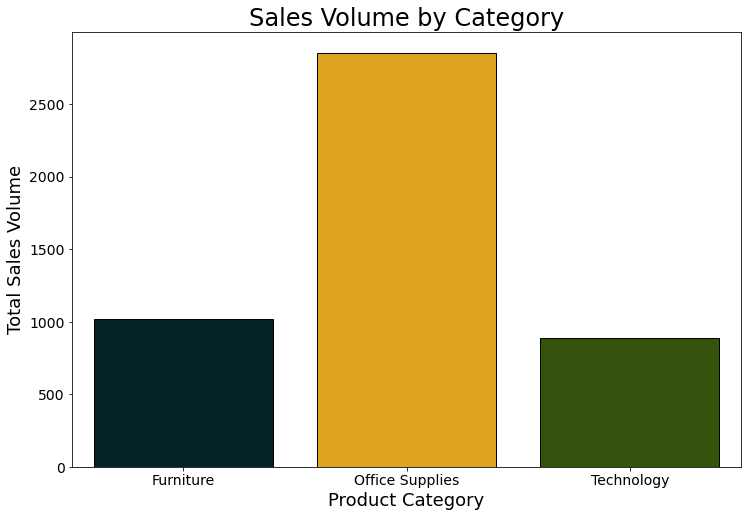

In [6]:
plt.figure(figsize=(12,8))
canva_palette = ['#002729', '#FFB000', '#375F00', '#707E00', '#B39B00']
sns.barplot(data=train, x='category', y='quantity', 
            estimator=sum, ci=None, ec='black', palette=canva_palette)
plt.title('Sales Volume by Category', fontsize=24)
plt.ylabel('Total Sales Volume', fontsize=18)
plt.xlabel('Product Category', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('sales_volume_by_category.jpeg')
plt.show()

 TODO [INSERT STATISTICAL TEST HERE]

#### Is there a category of product that has higher profit-per-product than the others?

In [7]:
# average sales_per_product by category
train.groupby('category').mean()[['profit_per_product']]

,profit_per_product
category,
Furniture,1.668842
Office Supplies,4.773817
Technology,20.180264


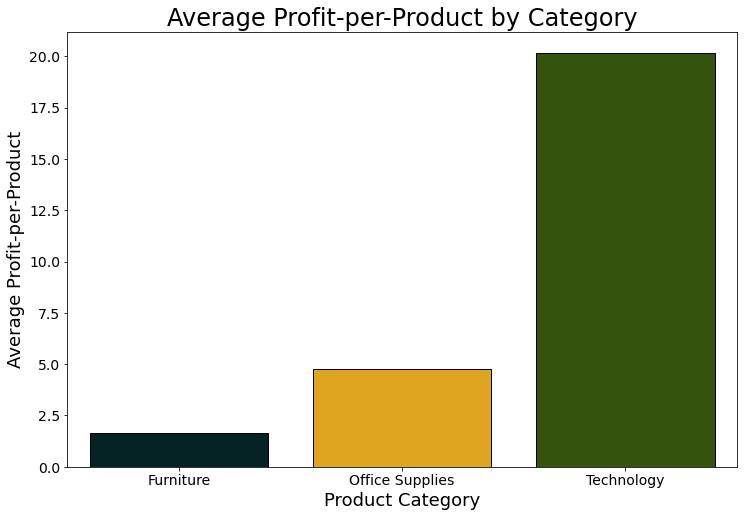

In [8]:
plt.figure(figsize=(12,8))
canva_palette = ['#002729', '#FFB000', '#375F00', '#707E00', '#B39B00']
sns.barplot(data=train, x='category', y='profit_per_product', 
            ci=None, ec='black', palette=canva_palette)
plt.title('Average Profit-per-Product by Category', fontsize=24)
plt.ylabel('Average Profit-per-Product', fontsize=18)
plt.xlabel('Product Category', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('profit_per_product_by_category.jpeg')
plt.show()

TODO: insert statistical test here

We found that the Technology sector has far-and-away the highest profit margins, yet has plenty of room for growth in terms of sales volume. For these reasons, we will recommend expanding the Technology product line. 

# Analysis/Forecasting

To simulate an expansion of the technology product line, we will take a look at data for 2017 (test), and replicate all instances of sales of technology products, then add those duplicate instances back into the dataframe. This will simulate doubling sales volume, while maintaining the dimensionality of those sales (differing profit margins, etc).

In [9]:
hypo_tech_sales_17 = test[test.category == 'Technology']
hypothetical_17 = pd.concat([test, hypo_tech_sales_17])

In [10]:
profits = pd.DataFrame()
profits['actual_2017'] = test.resample('M')['profit'].sum()
profits['projected_2017'] = hypothetical_17.resample('M')['profit'].sum()
profits['difference'] = profits.projected_2017 - profits.actual_2017
profits['difference_pct'] = profits.difference / profits.actual_2017
profits['rolling_total_actual'] = profits.actual_2017.cumsum()
profits['rolling_total_projected'] = profits.projected_2017.cumsum()
profits.index = profits.index.strftime('%b')
profits.index.name = 'month'

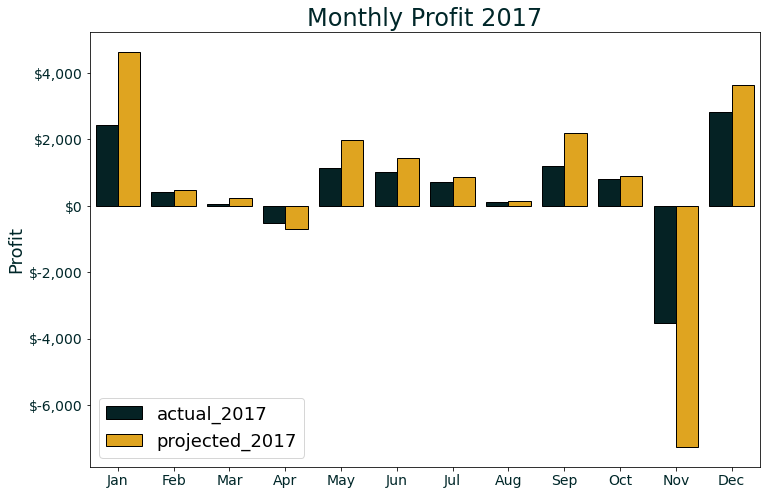

In [11]:
profits_melted = profits[['actual_2017', 'projected_2017']].melt(value_name='sales', ignore_index=False)

plt.figure(figsize=(12,8))
sns.barplot(data=profits_melted, x=profits_melted.index, y='sales', hue='variable', 
            palette=canva_palette, ec='black')
plt.title('Monthly Profit 2017', fontsize=24, color='#002729')
plt.ylabel('Profit', fontsize=18, color='#002729')
plt.xlabel(None)
plt.xticks(fontsize=14, color='#002729')
plt.yticks(fontsize=14, color='#002729')
plt.legend(loc='lower left', fontsize=18)
ax = plt.gca()
ax.set_yticklabels([f'${tick:,.0f}' for tick in ax.get_yticks()])
plt.savefig('fig_monthly_profit_barplot.jpeg')
plt.show()

While this resulted in higher profits in most months, we see that it also, in months where there were losses, those losses were also magnified. 

These losses are likely due to sales that included significant discounts. 

For this reason, we also recommend discontinuing any discounts greater than 35%

In [12]:
hypo_tech_sales_17 = test[test.category == 'Technology']
hypo_tech_sales_17 = hypo_tech_sales_17[hypo_tech_sales_17.discount <= .35]
hypothetical_17 = pd.concat([test, hypo_tech_sales_17])


In [13]:
profits = pd.DataFrame()
profits['actual_2017'] = test.resample('M')['profit'].sum()
profits['projected_2017'] = hypothetical_17.resample('M')['profit'].sum()
profits['difference'] = profits.projected_2017 - profits.actual_2017
profits['difference_pct'] = profits.difference / profits.actual_2017
profits['rolling_total_actual'] = profits.actual_2017.cumsum()
profits['rolling_total_projected'] = profits.projected_2017.cumsum()
profits.index = profits.index.strftime('%b')
profits.index.name = 'month'

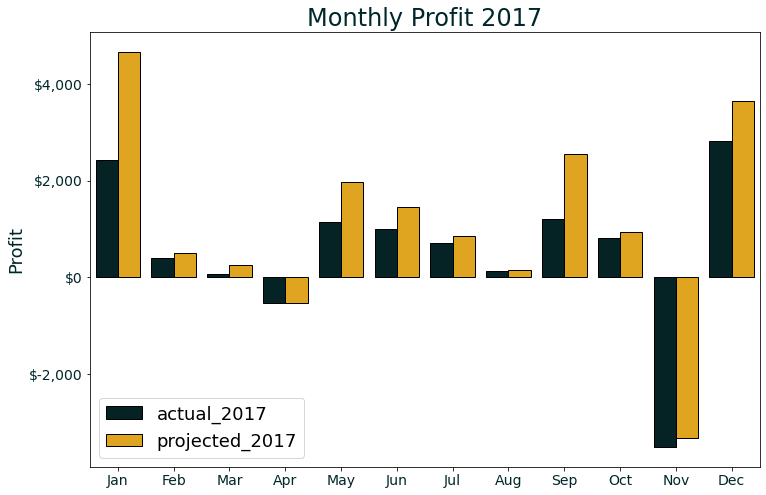

In [14]:
profits_melted = profits[['actual_2017', 'projected_2017']].melt(value_name='sales', ignore_index=False)

plt.figure(figsize=(12,8))
sns.barplot(data=profits_melted, x=profits_melted.index, y='sales', hue='variable', 
            palette=canva_palette, ec='black')
plt.title('Monthly Profit 2017', fontsize=24, color='#002729')
plt.ylabel('Profit', fontsize=18, color='#002729')
plt.xlabel(None)
plt.xticks(fontsize=14, color='#002729')
plt.yticks(fontsize=14, color='#002729')
plt.legend(loc='lower left', fontsize=18)
ax = plt.gca()
ax.set_yticklabels([f'${tick:,.0f}' for tick in ax.get_yticks()])
plt.savefig('fig_monthly_profit_barplot.jpeg')
plt.show()

Now, we retain our gains in profit, while reducing the severity of our losses.

In [15]:
# project monthly difference in profit
profits.difference_pct.mean()

0.631450651463487

In [16]:
# project annual difference in profit
(profits.projected_2017.sum() - profits.actual_2017.sum()) / profits.actual_2017.sum()

0.9649395879939442

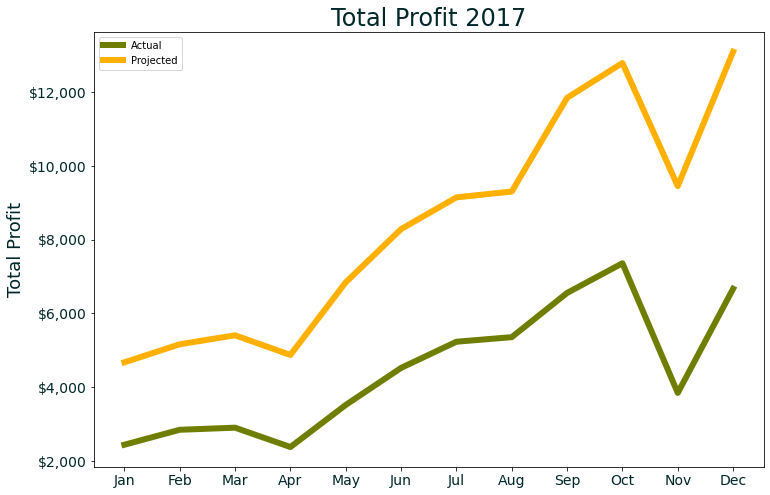

In [17]:
plt.figure(figsize=(12,8))
sns.lineplot(data=profits, x=profits.index, y='rolling_total_actual', 
             color='#707E00', label='Actual', lw=6)
sns.lineplot(data=profits, x=profits.index, y='rolling_total_projected', 
             color='#FFB000', label='Projected', lw=6)
plt.title('Total Profit 2017', fontsize=24, color='#002729')
plt.ylabel('Total Profit', fontsize=18, color='#002729')
plt.xlabel(None)
plt.xticks(fontsize=14, color='#002729')
plt.yticks(fontsize=14, color='#002729')
ax = plt.gca()
ax.set_yticklabels([f'${tick:,.0f}' for tick in ax.get_yticks()])
plt.savefig('fig_total_profit_2017.jpeg')
plt.show()